In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

plt.style.use('ggplot')

%matplotlib inline

In [3]:
def save_model(classifier, model_type, n_est, hz):
    import m2cgen as m2c
    code = m2c.export_to_python(classifier)
    PATH = f'models/inf_time_test/{model_type}/{model_type}_{n_est}est_{hz}hz.py'
    with open(PATH,'w') as f:
        f.writelines(code)

    return PATH

In [4]:
def train_random_forest(X_train, X_test, y_train, y_test, n_est, hz):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn import metrics
    
    clf = RandomForestClassifier(random_state=42, n_estimators=n_est)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred, average='macro')
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    recall = metrics.recall_score(y_test, y_pred, average='macro')

    path = save_model(classifier=clf, model_type='random_forest', n_est=n_est, hz=hz)

    return accuracy, f1, precision, recall, clf

In [5]:
df_25hz = pd.read_csv('data/transformed/20210529_v2_data_all_25hz.csv').reset_index(drop=True)
df_100hz = pd.read_csv('data/transformed/20210529_v2_data_all_100hz.csv').reset_index(drop=True)

df_train_25hz = df_25hz.dropna(axis=0)
df_train_100hz = df_100hz.dropna(axis=0)

X_train_25hz, X_test_25hz, y_train_25hz, y_test_25hz = train_test_split(
        df_train_25hz.drop(['label','shift'],axis=1), df_train_25hz['label'], test_size=0.3, random_state=42)

X_train_100hz, X_test_100hz, y_train_100hz, y_test_100hz = train_test_split(
        df_train_100hz.drop(['label','shift'],axis=1), df_train_100hz['label'], test_size=0.3, random_state=42)

In [6]:
for n_est in [3,4,5,10]:
    print(f'\nRandom Forest - 25hz - {n_est}')
    train_random_forest(X_train_25hz, X_test_25hz, y_train_25hz, y_test_25hz, n_est, 25)
    print('-' * 60)

for n_est in [3,4,5,10]:
    print(f'\nRandom Forest - 100hz - {n_est}')
    train_random_forest(X_train_100hz, X_test_100hz, y_train_100hz, y_test_100hz, n_est, 100)
    print('-' * 60)


Random Forest - 25hz - 3
------------------------------------------------------------

Random Forest - 25hz - 4
------------------------------------------------------------

Random Forest - 25hz - 5
------------------------------------------------------------

Random Forest - 25hz - 10
------------------------------------------------------------

Random Forest - 100hz - 3
------------------------------------------------------------

Random Forest - 100hz - 4
------------------------------------------------------------

Random Forest - 100hz - 5
------------------------------------------------------------

Random Forest - 100hz - 10
------------------------------------------------------------


In [7]:
from models.inf_time_test.random_forest import (
        random_forest_3est_25hz,
        random_forest_4est_25hz,
        random_forest_5est_25hz, 
        random_forest_10est_25hz,
        random_forest_3est_100hz,
        random_forest_4est_100hz,
        random_forest_5est_100hz, 
        random_forest_10est_100hz
    )

In [8]:
test_data_25hz = pd.read_csv('data/transformed/20210529_v2_data_all_25hz.csv').reset_index(drop=True).drop(['label','shift'], axis=1).loc[0]
test_data_100hz = pd.read_csv('data/transformed/20210529_v2_data_all_100hz.csv').reset_index(drop=True).drop(['label','shift'], axis=1).loc[0]

In [9]:
m2c_time_test_setup = {
    'random_forest': [
        (random_forest_3est_25hz, test_data_25hz, 25, 3),
        (random_forest_4est_25hz, test_data_25hz, 25, 4),
        (random_forest_5est_25hz, test_data_25hz, 25, 5),
        (random_forest_10est_25hz, test_data_25hz, 25, 10),
        (random_forest_3est_100hz, test_data_100hz, 100, 3),
        (random_forest_4est_100hz, test_data_100hz, 100, 4),
        (random_forest_5est_100hz, test_data_100hz, 100, 5),
        (random_forest_10est_100hz, test_data_100hz, 100, 10)
    ]
}

In [13]:
from statistics import mean

m2c_time_data_rf = []            

for t_item in m2c_time_test_setup['random_forest']:
    model = t_item[0]
    test_data = t_item[1]
    hz = t_item[2]
    n_est = t_item[3]

    res_time = get_ipython().run_line_magic('timeit', '-o model.score(test_data)')

    # TODO fix data collection
    m2c_time_data_rf.append({'hz':hz ,'estimators': n_est, 'time':mean(res_time.timings)})
#     m2c_time_data_rf['hz'] = hz
#     m2c_time_data_rf['estimators'] = n_est
#     m2c_time_data_rf['time'] = mean(res_time.timings)
    

177 us +- 3.18 us per loop (mean +- std. dev. of 7 runs, 10000 loops each)
274 us +- 12 us per loop (mean +- std. dev. of 7 runs, 1000 loops each)
336 us +- 10.1 us per loop (mean +- std. dev. of 7 runs, 1000 loops each)
701 us +- 21.2 us per loop (mean +- std. dev. of 7 runs, 1000 loops each)
200 us +- 21.1 us per loop (mean +- std. dev. of 7 runs, 10000 loops each)
269 us +- 20.6 us per loop (mean +- std. dev. of 7 runs, 1000 loops each)
341 us +- 10.5 us per loop (mean +- std. dev. of 7 runs, 1000 loops each)
674 us +- 52.9 us per loop (mean +- std. dev. of 7 runs, 1000 loops each)


In [16]:
m2c_df = pd.DataFrame(m2c_time_data_rf)
m2c_df['device'] = 'local'
m2c_df.to_csv('output/inference_time_rf_estimators_50hz.csv', index=False)

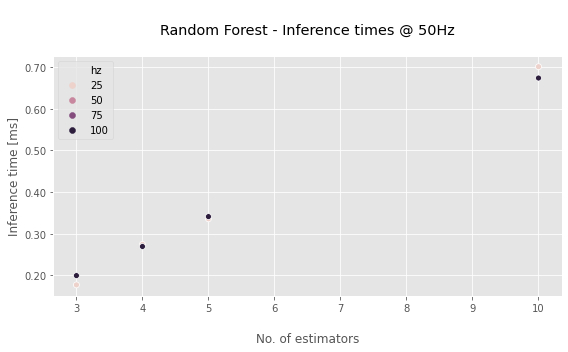

In [21]:
import matplotlib.ticker as tick

plt.figure(figsize=(8,5))
sns.scatterplot(data=m2c_df, x='estimators', y='time', hue='hz')

plt.title('\nRandom Forest - Inference times @ 50Hz\n')
plt.xlabel('\nNo. of estimators')
plt.ylabel('Inference time [ms]')

plt.gca().yaxis.set_major_formatter(tick.FuncFormatter(lambda x, post: f'{(x * 1000):.2f}'))
plt.tight_layout()

## Inference on ESP32

In [ ]:
time_esp32_25_3 = [1678,1188,1175,1176,1175,1176,1175,1176,1175,1176,1176,1176,1175,1176,1176,1176,1175,1176,1176,1176]
time_esp32_25_4 = [2054,1575,1557,1557,1557,1557,1556,1557,1566,1557,1557,1557,1557,1557,1556,1564,1556,1556,1556,1565]
time_esp32_25_5 = [2490,1994,1982,1987,1982,1983,1982,1988,1982,1981,1983,1982,1988,1982,1982,1982,1990,1982,1982,1982]
time_esp32_25_10 = [4157,3654,3640,3640,3640,3643,3640,3643,3642,3643,3633,3635,3633,3636,3634,3636,3633,3635,3633,3636]

time_esp32_100_3 = [1738,1235,1226,1222,1223,1226,1223,1223,1231,1223,1222,1228,1222,1223,1230,1223,1223,1223,1222,1223]
time_esp32_100_4 = [2152,1648,1636,1637,1636,1645,1636,1637,1637,1637,1636,1636,1636,1636,1637,1637,1645,1636,1637,1637]
time_esp32_100_5 = [2638,2132,2122,2121,2129,2121,2121,2121,2122,2126,2121,2121,2122,2125,2121,2121,2122,2121,2127,2121]
time_esp32_100_10 = [4568,4062,4051,4053,4048,4052,4051,4046,4044,4045,4043,4046,4044,4045,4044,4046,4044,4046,4044,4044]
